In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


In [42]:
df = pd.read_csv("dynamic_pricing.csv")

In [43]:
kpi = {
    "Avg_Historical_Price": round(df["Historical_Cost_of_Ride"].mean(), 2),
    "Median_Historical_Price": round(df["Historical_Cost_of_Ride"].median(), 2),
    "Avg_Riders": round(df["Number_of_Riders"].mean(), 2),
    "Avg_Drivers": round(df["Number_of_Drivers"].mean(), 2),
}
print("Milestone 1 KPIs:\n", kpi)

Milestone 1 KPIs:
 {'Avg_Historical_Price': np.float64(372.5), 'Median_Historical_Price': 362.02, 'Avg_Riders': np.float64(60.37), 'Avg_Drivers': np.float64(27.08)}


In [44]:
int_cols = ["Number_of_Riders", "Number_of_Drivers", "Number_of_Past_Rides", "Expected_Ride_Duration"]
float_cols = ["Average_Ratings", "Historical_Cost_of_Ride"]
cat_cols = ["Location_Category", "Customer_Loyalty_Status", "Time_of_Booking", "Vehicle_Type"]

In [45]:
for c in int_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce").astype("Int64")
for c in float_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")
for c in cat_cols:
    df[c] = df[c].astype("string").str.strip()


In [46]:
# Handle missing values
df[int_cols + float_cols] = df[int_cols + float_cols].fillna(df[int_cols + float_cols].median())
df[cat_cols] = df[cat_cols].fillna("Unknown")

In [47]:
df.loc[~df["Average_Ratings"].between(1, 5), "Average_Ratings"] = df["Average_Ratings"].median()


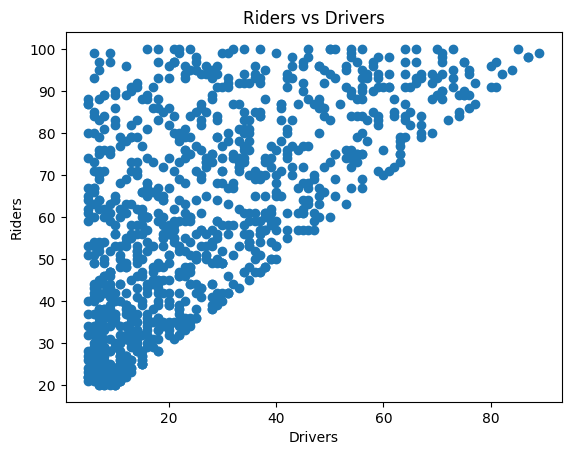

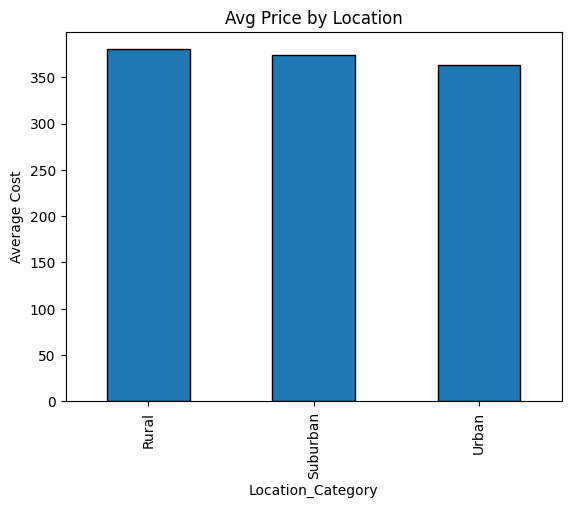

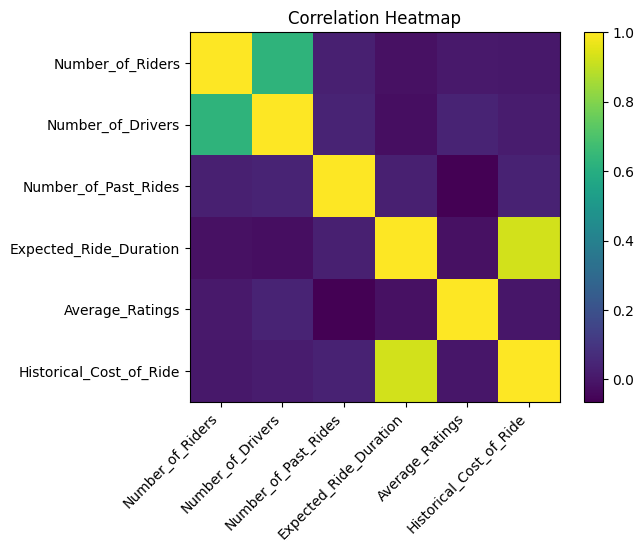

In [48]:
plt.scatter(df["Number_of_Drivers"], df["Number_of_Riders"])
plt.title("Riders vs Drivers")
plt.xlabel("Drivers")
plt.ylabel("Riders")
plt.show()
df.groupby("Location_Category")["Historical_Cost_of_Ride"].mean().plot(kind="bar", edgecolor="black", title="Avg Price by Location")
plt.ylabel("Average Cost")
plt.show()
corr = df[int_cols + float_cols].corr()
plt.imshow(corr, interpolation="nearest")
plt.title("Correlation Heatmap")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha="right")
plt.yticks(range(len(corr.columns)), corr.columns)
plt.colorbar()
plt.show()

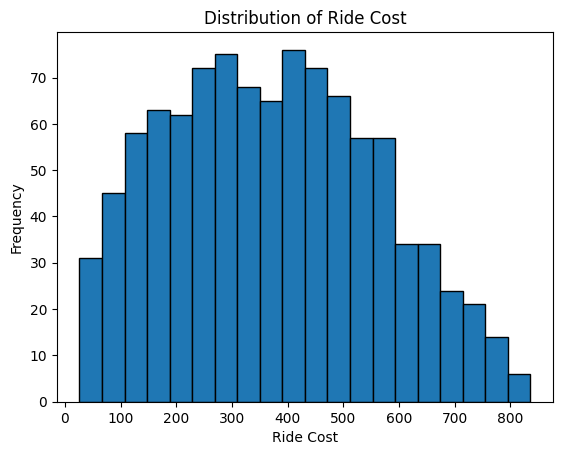

In [49]:
df["Historical_Cost_of_Ride"].plot(kind="hist", bins=20, edgecolor="black", title="Distribution of Ride Cost")
plt.xlabel("Ride Cost")
plt.show()

In [50]:
print("\nKPI Results:")
print("Average Historical Price:", round(df["Historical_Cost_of_Ride"].mean(), 2))
print("Median Historical Price:", round(df["Historical_Cost_of_Ride"].median(), 2))
print("Average Riders per Driver:", round((df["Number_of_Riders"]/df["Number_of_Drivers"]).mean(), 2))


KPI Results:
Average Historical Price: 372.5
Median Historical Price: 362.02
Average Riders per Driver: 3.24


In [51]:
df["Competitor_Price_Index"] = np.random.uniform(0.9, 1.1, size=len(df))
df["Cost_per_Min"] = df["Historical_Cost_of_Ride"] / df["Expected_Ride_Duration"].replace(0, np.nan)
df["Driver_to_Rider_Ratio"] = df["Number_of_Drivers"] / df["Number_of_Riders"].replace(0, np.nan)
df["Inventory_Health_Index"] = df["Number_of_Drivers"] / (df["Number_of_Riders"] + 1)
loyalty_map = {"Bronze": 0, "Silver": 1, "Gold": 2, "Platinum": 3}
df["Loyalty_Score"] = df["Customer_Loyalty_Status"].map(loyalty_map).fillna(0).astype(int)
df["Peak"] = df["Time_of_Booking"].apply(lambda x: 1 if x in ["Evening", "Night"] else 0)
df["Rider_Driver_Ratio"] = df["Number_of_Riders"] / df["Number_of_Drivers"].replace(0, np.nan)
df["Supply_Tightness"] = df["Rider_Driver_Ratio"] * df["Peak"]
veh_map = {"Economy": 1.0, "Premium": 1.5}
df["Vehicle_Factor"] = df["Vehicle_Type"].map(veh_map).fillna(1.0)
base_rate = 2.0
df["baseline_price"] = df["Expected_Ride_Duration"] * df["Vehicle_Factor"] * base_rate
df["competitor_price"] = df["baseline_price"] * df["Competitor_Price_Index"]
df["p_complete"] = 0.7 + (0.05 * df["Loyalty_Score"]) + (0.01 * df["Driver_to_Rider_Ratio"])
df["p_complete"] = df["p_complete"].clip(0, 1)
df["price"] = (df["baseline_price"] * 0.5 + df["competitor_price"] * 0.3 + (df["Supply_Tightness"] * 5) * 0.2)

print(df.head())

   Number_of_Riders  Number_of_Drivers Location_Category  \
0                90                 45             Urban   
1                58                 39          Suburban   
2                42                 31             Rural   
3                89                 28             Rural   
4                78                 22             Rural   

  Customer_Loyalty_Status  Number_of_Past_Rides  Average_Ratings  \
0                  Silver                    13             4.47   
1                  Silver                    72             4.06   
2                  Silver                     0             3.99   
3                 Regular                    67             4.31   
4                 Regular                    74             3.77   

  Time_of_Booking Vehicle_Type  Expected_Ride_Duration  \
0           Night      Premium                      90   
1         Evening      Economy                      43   
2       Afternoon      Premium                      76  

In [52]:

def gm_pct(price, cost):
    """Compute gross margin % as decimal"""
    return (price - cost) / price if price > 0 else 0.0


STABILITY_PCT = 0.15
MIN_GM_PCT = 0.12
COMP_CAP = {"Economy": 1.05, "Premium": 1.08}
COMP_FLOOR = {"Economy": 0.90, "Premium": 0.88}

def row_price_bounds(row):
    base = row["baseline_price"]
    cost = row["Historical_Cost_of_Ride"]
    veh = row["Vehicle_Type"]
    comp = row["competitor_price"]

    # Price stability
    lo, hi = base*(1-STABILITY_PCT), base*(1+STABILITY_PCT)

    # GM constraint
    min_gm_price = cost / (1-MIN_GM_PCT)
    lo = max(lo, min_gm_price)

    # Competitor constraints
    floor = COMP_FLOOR.get(veh, 0.9)
    cap = COMP_CAP.get(veh, 1.05)
    lo = max(lo, comp*floor)
    hi = min(hi, comp*cap)

    if hi < lo: hi = lo
    return lo, hi

In [53]:
def choose_optimal_price(row):
    lo, hi = row_price_bounds(row)


    center = row["baseline_price"] + row["Supply_Tightness"] * 5
    center = np.clip(center, lo, hi)


    grid = np.linspace(lo, hi, 11)

    best_price = center
    best_revenue = best_price * row["p_complete"]

    for p in grid:
        gm = gm_pct(p, row["Historical_Cost_of_Ride"])
        if gm < MIN_GM_PCT: continue

        p_complete_est = row["p_complete"] + 0.01*(p - row["baseline_price"])/row["baseline_price"]
        p_complete_est = np.clip(p_complete_est, 0, 1)
        revenue = p * p_complete_est
        if revenue > best_revenue:
            best_revenue = revenue
            best_price = p
    return pd.Series([best_price, best_revenue], index=["opt_price", "est_revenue"])


In [54]:
df[["opt_price", "est_revenue"]] = df.apply(choose_optimal_price, axis=1)

In [55]:
avg_gm = ((df["opt_price"] - df["Historical_Cost_of_Ride"]) / df["opt_price"]).mean()
avg_price = df["opt_price"].mean()
avg_revenue = df["est_revenue"].mean()
print("\n=== KPIs for Optimized Pricing ===")
print(f"Average Optimized Price: {round(avg_price,2)}")
print(f"Average Estimated Revenue: {round(avg_revenue,2)}")
print(f"Average Gross Margin: {round(avg_gm*100,2)}%")


=== KPIs for Optimized Pricing ===
Average Optimized Price: 423.42
Average Estimated Revenue: 321.06
Average Gross Margin: 12.02%


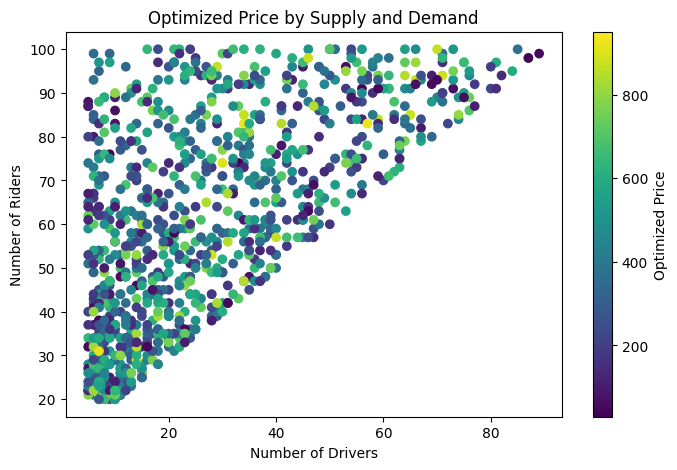

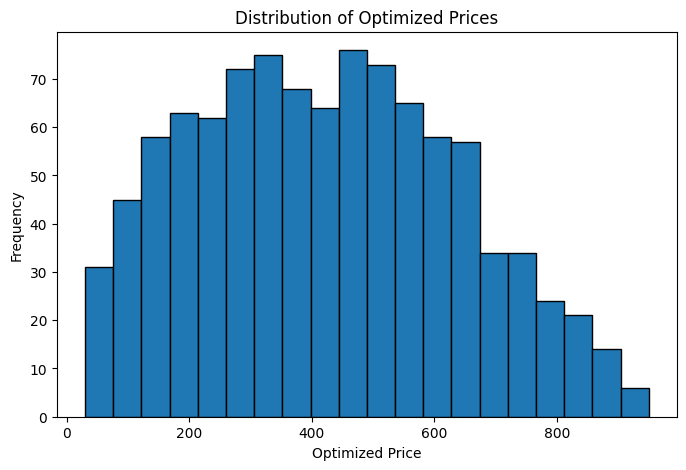

In [56]:
plt.figure(figsize=(8,5))
plt.scatter(df["Number_of_Drivers"], df["Number_of_Riders"], c=df["opt_price"], cmap="viridis")
plt.colorbar(label="Optimized Price")
plt.xlabel("Number of Drivers")
plt.ylabel("Number of Riders")
plt.title("Optimized Price by Supply and Demand")
plt.show()

plt.figure(figsize=(8,5))
plt.hist(df["opt_price"], bins=20, edgecolor="black")
plt.title("Distribution of Optimized Prices")
plt.xlabel("Optimized Price")
plt.ylabel("Frequency")
plt.show()


In [57]:
def policy_audit(df):
    # Price stability
    stable = df["opt_price"].between(df["baseline_price"]*0.85, df["baseline_price"]*1.15).all()
    # GM ≥ 12%
    gm_ok = ((df["opt_price"] - df["Historical_Cost_of_Ride"])/df["opt_price"] >= MIN_GM_PCT).all()
    # Competitiveness
    comp_ok = ((df["opt_price"] <= df["competitor_price"]*1.08) &
               (df["opt_price"] >= df["competitor_price"]*0.88)).all()
    # No increase in cancellation
    cancel_ok = (df["p_complete"] <= 1).all()
    return {"Price Stability": stable, "GM ≥ 12%": gm_ok, "Competitor Check": comp_ok, "Cancellation Check": cancel_ok}

audit_results = policy_audit(df)
print("\n=== Policy Audit Results ===")
for k,v in audit_results.items():
    print(f"{k}: {v}")


=== Policy Audit Results ===
Price Stability: False
GM ≥ 12%: False
Competitor Check: False
Cancellation Check: True


In [58]:
df.head(10)

,Number_of_Riders,Number_of_Drivers,Location_Category,Customer_Loyalty_Status,Number_of_Past_Rides,Average_Ratings,Time_of_Booking,Vehicle_Type,Expected_Ride_Duration,Historical_Cost_of_Ride,...,Peak,Rider_Driver_Ratio,Supply_Tightness,Vehicle_Factor,baseline_price,competitor_price,p_complete,price,opt_price,est_revenue
0,90,45,Urban,Silver,13,4.47,Night,Premium,90,284.257273,...,1,2.0,2.0,1.5,270.0,274.684756,0.755,219.405427,323.019628,243.879819
1,58,39,Suburban,Silver,72,4.06,Evening,Economy,43,173.874753,...,1,1.487179,1.487179,1.0,86.0,92.733238,0.756724,72.307151,197.584946,152.080962
2,42,31,Rural,Silver,0,3.99,Afternoon,Premium,76,329.795469,...,0,1.354839,0.0,1.5,228.0,243.413735,0.757381,187.02412,374.767578,286.254270
3,89,28,Rural,Regular,67,4.31,Afternoon,Premium,134,470.201232,...,0,3.178571,0.0,1.5,402.0,363.851243,0.703146,310.155373,534.319582,377.463442
4,78,22,Rural,Regular,74,3.77,Afternoon,Economy,149,579.681422,...,0,3.545455,0.0,1.0,298.0,282.725173,0.702821,233.817552,658.728889,470.942086
5,59,35,Urban,Silver,83,3.51,Night,Economy,128,339.955361,...,1,1.685714,1.685714,1.0,256.0,256.375869,0.755932,206.598475,386.312910,292.026369
6,93,43,Suburban,Regular,44,4.41,Afternoon,Premium,16,104.061541,...,0,2.162791,0.0,1.5,48.0,50.562826,0.704624,39.168848,118.251751,85.053688
7,62,39,Rural,Gold,83,3.59,Afternoon,Premium,47,235.811864,...,0,1.589744,0.0,1.5,141.0,127.446971,0.80629,108.734091,267.968027,216.060027
8,79,14,Rural,Silver,71,3.74,Evening,Economy,128,501.412517,...,1,5.642857,5.642857,1.0,256.0,280.308993,0.751772,217.735555,569.786952,435.334014
9,42,6,Rural,Silver,21,3.85,Night,Premium,128,398.993365,...,1,7.0,7.0,1.5,384.0,398.121882,0.751429,318.436565,453.401551,341.518327
